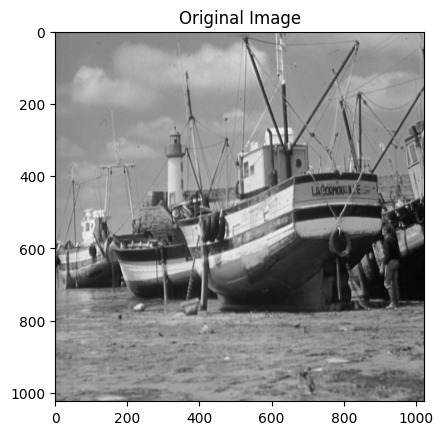

Encryption time: 12.334868 seconds
Encryption Throughput: 0.680073 Mbps


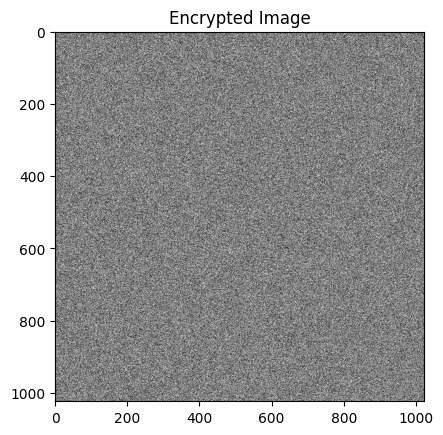

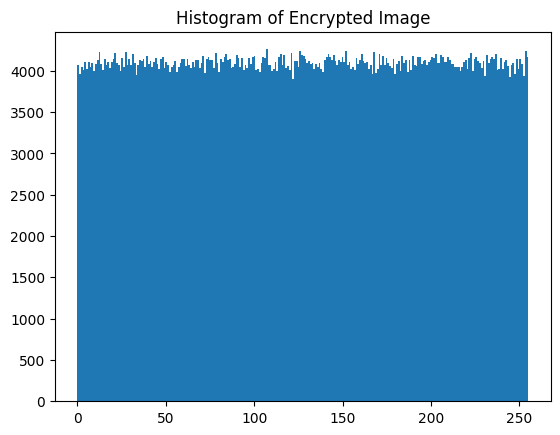

Entropy: 7.999799
Horizontal correlation: 0.000486
Vertical correlation: -0.000406
Diagonal correlation: -0.000053
Chi-square statistic: 291.187988
P-value: 0.059199


In [ ]:
import numpy as np
import cv2
import hashlib
import time
import matplotlib.pyplot as plt
from scipy.stats import entropy as scipy_entropy, chisquare # Added chisquare
from scipy.ndimage import correlate
import os

def generate_lorenz_sequence(sigma, rho, beta, x0, y0, z0, dt, N):
    x = np.zeros(N)
    y = np.zeros(N)
    z = np.zeros(N)
    s_seq = np.zeros(N)

    x[0] = x0
    y[0] = y0
    z[0] = z0
    s_seq[0] = (x0 + y0 + z0) % 1

    for i in range(1, N):
        x[i] = x[i-1] + sigma * (y[i-1] - x[i-1]) * dt
        y[i] = y[i-1] + (x[i-1] * (rho - z[i-1]) - y[i-1]) * dt
        z[i] = z[i-1] + (x[i-1] * y[i-1] - beta * z[i-1]) * dt
        s_seq[i] = (x[i] + y[i] + z[i]) % 1

    x1 = np.zeros(N)
    y1 = np.zeros(N)
    z1 = np.zeros(N)

    for i in range(1, N):
        x1[i] = (x[i] + y[i]) % 1
        y1[i] = (y[i] + z[i]) % 1
        z1[i] = (z[i] + x[i]) % 1

    # Normalize to [0, 255] and convert to uint8
    x_seq = (x1 * 255).astype(np.uint8)
    y_seq = (y1 * 255).astype(np.uint8)
    z_seq = (z1 * 255).astype(np.uint8)

    # Reshape each sequence to sqrt(N) x sqrt(N)
    side_length = int(np.sqrt(N))
    x_seq = x_seq[:side_length*side_length].reshape(side_length, side_length)
    y_seq = y_seq[:side_length*side_length].reshape(side_length, side_length)
    z_seq = z_seq[:side_length*side_length].reshape(side_length, side_length)

    return x_seq, y_seq, z_seq, s_seq

def shift_operator(state):
    N = state.shape[0]
    new_state = np.zeros_like(state, dtype=complex)

    for i in range(N):
        new_state[(i-1) % N, 0] += state[i, 0]  # shift left for first component
        new_state[(i+1) % N, 1] += state[i, 1]  # shift right for second component

    return new_state

def generate_QW_SBox(g, init_position, T, theta):
    N = 256
    state = np.zeros((N, 2), dtype=complex)

    # Set random seed and initialize coin
    np.random.seed(g)
    init_coin = np.random.rand(2) + 1j * np.random.rand(2)
    state[init_position, :] = init_coin / np.linalg.norm(init_coin)

    # Coin operator
    C = np.array([
        [np.cos(theta), np.sin(theta)],
        [np.sin(theta), -np.cos(theta)]
    ])

    # Quantum walk evolution
    for t in range(T):
        # Coin operation
        for i in range(N):
            state[i, :] = C @ state[i, :]

        # Shift operation
        state = shift_operator(state)

    # Probability distribution
    prob_dist = np.abs(state[:, 0])**2 + np.abs(state[:, 1])**2
    prob_dist = prob_dist / np.sum(prob_dist)

    # Nonlinear transformation
    nonlinear_prob = -np.log10(prob_dist + np.finfo(float).eps)
    nonlinear_prob = np.mod(nonlinear_prob * 1e5, 256)

    # Generate S-Box
    idx = np.argsort(nonlinear_prob)
    SBox = idx.astype(np.uint8)

    return SBox

def evaluate_correlation(encrypted_image):
    img = encrypted_image.astype(float)

    # Horizontal correlation
    horizontal_correlation = np.corrcoef(img[:, :-1].flatten(), img[:, 1:].flatten())[0, 1]

    # Vertical correlation
    vertical_correlation = np.corrcoef(img[:-1, :].flatten(), img[1:, :].flatten())[0, 1]

    # Diagonal correlation
    diagonal_correlation = np.corrcoef(img[:-1, :-1].flatten(), img[1:, 1:].flatten())[0, 1]

    return horizontal_correlation, vertical_correlation, diagonal_correlation

def entropy(image):
    """Calculate entropy of an image"""
    hist, _ = np.histogram(image, bins=256, range=(0, 255))
    prob = hist / hist.sum()
    prob = prob[prob > 0]  # remove zero probabilities
    return -np.sum(prob * np.log2(prob))

def calculate_chi_square_goodness_of_fit(image):

    hist, _ = np.histogram(image, bins=256, range=(0, 255))
    observed_frequencies = hist
    total_pixels = image.size
    expected_frequency_per_bin = total_pixels / 256.0 # For a perfect uniform distribution
    expected_frequencies = np.full(256, expected_frequency_per_bin)

    chi2_stat, p_value = chisquare(f_obs=observed_frequencies, f_exp=expected_frequencies)
    return chi2_stat, p_value

def main():
    # Start timing and memory monitoring
    start_time = time.time()

    # Read and preprocess image
    I = cv2.imread('/media/boat.512.tiff')
    if I is None:
        raise FileNotFoundError("Image 'alarm.tiff' not found")

    if len(I.shape) == 3:
        I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

    N = 1024
    I = cv2.resize(I, (N, N))

    # Display original image
    plt.figure()
    plt.imshow(I, cmap='gray')
    plt.title('Original Image')
    plt.show()

    # Generate Lorenz sequences
    X, Y, Z, S = generate_lorenz_sequence(
        10.99999999, 28.11111111, 2.66666666,
        0.22222222, 0.63333333, 0.44444444, 0.02, N**2
    )

    # Compute SHA-256 hash for theta_x
    I_bytes = I.tobytes()
    hash_bytes = hashlib.sha256(I_bytes).digest()   # 32 bytes (256 bits)

    # Interpret full 256-bit hash as one integer
    val = int.from_bytes(hash_bytes, byteorder='big', signed=False)

    # Normalize to [0,1)
    frac = val / (2**256 - 1)

    # Generate the rotation angle
    theta_x = 2*np.pi * frac

    # Generate QW S-Box for X
    QW_x = generate_QW_SBox(20, 100, 600, theta_x)

    # X encryption stage
    E_x = np.mod(I.astype(int) + X.astype(int), 256).astype(np.uint8)
    E_xx = np.zeros((N, N), dtype=np.uint8)

    for i in range(N):
        for j in range(N):
            E_xx[i, j] = QW_x[E_x[i, j]]

    E_xxx = np.zeros((N, N), dtype=np.uint8)
    for j in range(N):
        for i in range(N):
            E_xxx[i, j] = QW_x[E_xx[i, j]]

    # Compute SHA-256 hash for theta_y
    E_xxx_bytes = E_xxx.tobytes()
    hash_bytes = hashlib.sha256(E_xxx_bytes).digest()   # 32 bytes, 256 bits

    # Interpret the full 256-bit hash as a single integer
    val = int.from_bytes(hash_bytes, byteorder='big', signed=False)

    # Normalize to [0, 1)
    frac = val / (2**256 - 1)

    # Generate rotation angle theta_y
    theta_y = 2 * np.pi * frac


    # Generate QW S-Box for Y
    QW_y = generate_QW_SBox(80, 120, 750, theta_y)

    # Y encryption stage
    E_y = np.mod(E_xxx.astype(int) + Y.astype(int), 256).astype(np.uint8)
    E_yy = np.zeros((N, N), dtype=np.uint8)

    for i in range(N):
        for j in range(N):
            E_yy[i, j] = QW_y[E_y[i, j]]

    E_yyy = np.zeros((N, N), dtype=np.uint8)
    for j in range(N):
        for i in range(N):
            E_yyy[i, j] = QW_y[E_yy[i, j]]

    # Compute SHA-256 hash for theta_z
    E_yyy_bytes = E_yyy.tobytes()
    hash_bytes = hashlib.sha256(E_yyy_bytes).digest()   # 32 bytes, 256 bits

    # Interpret the full 256-bit hash as a single integer
    val = int.from_bytes(hash_bytes, byteorder='big', signed=False)

    # Normalize to [0, 1)
    frac = val / (2**256 - 1)

    # Generate rotation angle theta_z
    theta_z = 2 * np.pi * frac


    # Generate QW S-Box for Z
    QW_z = generate_QW_SBox(150, 20, 800, theta_z)

    # Z encryption stage
    E_z = np.mod(E_yyy.astype(int) + Z.astype(int), 256).astype(np.uint8)
    E_zz = np.zeros((N, N), dtype=np.uint8)

    for i in range(N):
        for j in range(N):
            E_zz[i, j] = QW_z[E_z[i, j]]

    E_zzz = np.zeros((N, N), dtype=np.uint8)
    for j in range(N):
        for i in range(N):
            E_zzz[i, j] = QW_z[E_zz[i, j]]

    # Shuffling the encrypted image
    E_zzz_vec = E_zzz.flatten()
    perm_idx = np.argsort(S[:len(E_zzz_vec)])
    E_vec = E_zzz_vec[perm_idx]
    E = E_vec.reshape((N, N))

    encryption_time = time.time() - start_time
    print(f"Encryption time: {encryption_time:.6f} seconds")

    # Calculate and print encryption throughput
    image_size_bits = N * N * 8  # N x N pixels, 8 bits per pixel (grayscale)
    encryption_throughput_mbps = (image_size_bits / encryption_time) / 1e6
    print(f"Encryption Throughput: {encryption_throughput_mbps:.6f} Mbps")

    # Display encrypted image
    plt.figure()
    plt.imshow(E, cmap='gray')
    plt.title('Encrypted Image')
    plt.show()

    # Display histogram of encrypted image
    plt.figure()
    plt.hist(E.flatten(), bins=256, range=(0, 255))
    plt.title('Histogram of Encrypted Image')
    plt.show()

    # Save encrypted image
    np.save('encrypted5.npy', E)
    thetakeys = [theta_x, theta_y, theta_z]
    np.save('thetakeys.npy', thetakeys)

    # Calculate metrics
    HH = entropy(E)
    print(f"Entropy: {HH:.6f}")

    a, b, c = evaluate_correlation(E)
    print(f"Horizontal correlation: {a:.6f}")
    print(f"Vertical correlation: {b:.6f}")
    print(f"Diagonal correlation: {c:.6f}")

    # Calculate Chi-square and p-value
    chi2_stat, p_value = calculate_chi_square_goodness_of_fit(E)
    print(f"Chi-square statistic: {chi2_stat:.6f}")
    print(f"P-value: {p_value:.6f}")

if __name__ == "__main__":
    main()

Decryption time: 12.330804 seconds
Decryption Throughput: 0.680297 Mbps


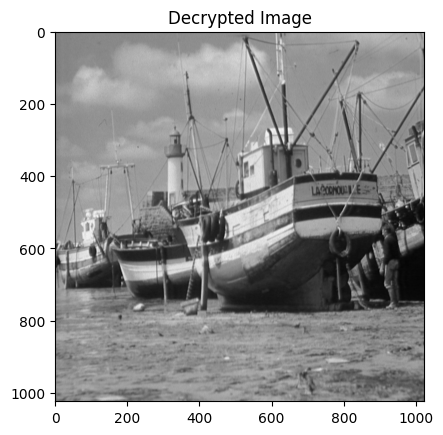

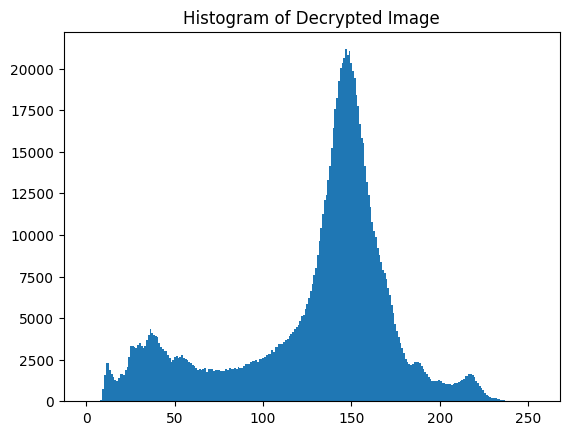

PSNR: inf
NCC: 1.000000
SSIM: 1.000000


/usr/local/lib/python3.12/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


In [ ]:
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def generate_lorenz_sequence(sigma, rho, beta, x0, y0, z0, dt, N):
    x = np.zeros(N)
    y = np.zeros(N)
    z = np.zeros(N)
    s_seq = np.zeros(N)

    x[0] = x0
    y[0] = y0
    z[0] = z0
    s_seq[0] = (x0 + y0 + z0) % 1

    for i in range(1, N):
        x[i] = x[i-1] + sigma * (y[i-1] - x[i-1]) * dt
        y[i] = y[i-1] + (x[i-1] * (rho - z[i-1]) - y[i-1]) * dt
        z[i] = z[i-1] + (x[i-1] * y[i-1] - beta * z[i-1]) * dt
        s_seq[i] = (x[i] + y[i] + z[i]) % 1

    x1 = np.zeros(N)
    y1 = np.zeros(N)
    z1 = np.zeros(N)

    for i in range(1, N):
        x1[i] = (x[i] + y[i]) % 1
        y1[i] = (y[i] + z[i]) % 1
        z1[i] = (z[i] + x[i]) % 1

    # Normalize to [0, 255] and convert to uint8
    x_seq = (x1 * 255).astype(np.uint8)
    y_seq = (y1 * 255).astype(np.uint8)
    z_seq = (z1 * 255).astype(np.uint8)

    # Reshape each sequence to sqrt(N) x sqrt(N)
    side_length = int(np.sqrt(N))
    x_seq = x_seq[:side_length*side_length].reshape(side_length, side_length)
    y_seq = y_seq[:side_length*side_length].reshape(side_length, side_length)
    z_seq = z_seq[:side_length*side_length].reshape(side_length, side_length)

    return x_seq, y_seq, z_seq, s_seq

def shift_operator(state):
    N = state.shape[0]
    new_state = np.zeros_like(state, dtype=complex)

    for i in range(N):
        new_state[(i-1) % N, 0] += state[i, 0]  # shift left for first component
        new_state[(i+1) % N, 1] += state[i, 1]  # shift right for second component

    return new_state

def generate_QW_SBox(g, init_position, T, theta):
    N = 256
    state = np.zeros((N, 2), dtype=complex)

    # Set random seed and initialize coin
    np.random.seed(g)
    init_coin = np.random.rand(2) + 1j * np.random.rand(2)
    state[init_position, :] = init_coin / np.linalg.norm(init_coin)

    # Coin operator
    C = np.array([
        [np.cos(theta), np.sin(theta)],
        [np.sin(theta), -np.cos(theta)]
    ])

    # Quantum walk evolution
    for t in range(T):
        # Coin operation
        for i in range(N):
            state[i, :] = C @ state[i, :]

        # Shift operation
        state = shift_operator(state)

    # Probability distribution
    prob_dist = np.abs(state[:, 0])**2 + np.abs(state[:, 1])**2
    prob_dist = prob_dist / np.sum(prob_dist)

    # Nonlinear transformation
    nonlinear_prob = -np.log10(prob_dist + np.finfo(float).eps)
    nonlinear_prob = np.mod(nonlinear_prob * 1e5, 256)

    # Generate S-Box
    idx = np.argsort(nonlinear_prob)
    SBox = idx.astype(np.uint8)

    return SBox

def generate_inverse_sbox(forwardSBox):
    """Generate inverse S-Box efficiently"""
    inverseSBox = np.zeros(256, dtype=np.uint8)
    for i in range(256):
        inverseSBox[forwardSBox[i]] = np.uint8(i)
    return inverseSBox

def main():
    # Start timing
    start_time = time.time()

    # Load saved keys and encrypted image
    try:
        thetakeys = np.load('thetakeys.npy')
        E = np.load('encrypted5.npy')
    except FileNotFoundError:
        print("Error: Could not find thetakeys.npy or encrypted5.npy")
        return

    N = 1024 # Changed N to 256 to match encryption image size

    # Step 1: Regenerate Lorenz sequences (must be identical to encryption)
    X, Y, Z, S = generate_lorenz_sequence(
        10.99999999, 28.11111111, 2.66666666,
        0.22222222, 0.63333333, 0.44444444, 0.02, N**2
    )

    # Reverse permutation
    E_vec = E.flatten()
    perm_idx = np.argsort(S[:len(E_vec)])
    inv_perm = np.argsort(perm_idx)
    D0_vec = E_vec[inv_perm]
    E_zzz = D0_vec.reshape((N, N))

    # Step 2: Generate forward S-Boxes only once
    QW_x = generate_QW_SBox(20, 100, 600, thetakeys[0])
    QW_y = generate_QW_SBox(80, 120, 750, thetakeys[1])
    QW_z = generate_QW_SBox(150, 20, 800, thetakeys[2])

    # Step 3: Build inverse S-Boxes efficiently
    IQW_x = generate_inverse_sbox(QW_x)
    IQW_y = generate_inverse_sbox(QW_y)
    IQW_z = generate_inverse_sbox(QW_z)

    # Step 4: Z-stage decryption
    D_z1 = np.zeros((N, N), dtype=np.uint8)
    for j in range(N):
        for i in range(N):
            D_z1[i, j] = IQW_z[E_zzz[i, j]]

    D_z2 = np.zeros((N, N), dtype=np.uint8)
    for i in range(N):
        for j in range(N):
            D_z2[i, j] = IQW_z[D_z1[i, j]]

    # Inverse modular addition with Z
    D_z = np.mod(D_z2.astype(int) - Z.astype(int) + 256, 256).astype(np.uint8)

    # Step 5: Y-stage decryption
    D_y1 = np.zeros((N, N), dtype=np.uint8)
    for j in range(N):
        for i in range(N):
            D_y1[i, j] = IQW_y[D_z[i, j]]

    D_y2 = np.zeros((N, N), dtype=np.uint8)
    for i in range(N):
        for j in range(N):
            D_y2[i, j] = IQW_y[D_y1[i, j]]

    # Inverse modular addition with Y
    D_y = np.mod(D_y2.astype(int) - Y.astype(int) + 256, 256).astype(np.uint8)

    # Step 6: X-stage decryption
    D_x1 = np.zeros((N, N), dtype=np.uint8)
    for j in range(N):
        for i in range(N):
            D_x1[i, j] = IQW_x[D_y[i, j]]

    D_x2 = np.zeros((N, N), dtype=np.uint8)
    for i in range(N):
        for j in range(N):
            D_x2[i, j] = IQW_x[D_x1[i, j]]

    # Inverse modular addition with X
    D_x3 = np.mod(D_x2.astype(int) - X.astype(int) + 256, 256).astype(np.uint8)

    decryption_time = time.time() - start_time
    print(f"Decryption time: {decryption_time:.6f} seconds")

    # Calculate and print decryption throughput
    image_size_bits = N * N * 8  # N x N pixels, 8 bits per pixel (grayscale)
    decryption_throughput_mbps = (image_size_bits / decryption_time) / 1e6
    print(f"Decryption Throughput: {decryption_throughput_mbps:.6f} Mbps")

    # Display decrypted image
    plt.figure()
    plt.imshow(D_x3, cmap='gray')
    plt.title('Decrypted Image')
    plt.show()

    # Display histogram of decrypted image
    plt.figure()
    plt.hist(D_x3.flatten(), bins=256, range=(0, 255))
    plt.title('Histogram of Decrypted Image')
    plt.show()
# Load original image for comparison
    I = cv2.imread('/media/boat.512.tiff')
    if I is None:
        print("Warning: Original image 'alarm.tiff' not found for comparison")
        return

    if len(I.shape) == 3:
        I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

    I = cv2.resize(I, (N, N))

    # Calculate metrics
    try:
        psnr_value = peak_signal_noise_ratio(I, D_x3)
        ncc_value = np.corrcoef(I.flatten(), D_x3.flatten())[0, 1]
        ssi_value = structural_similarity(I, D_x3)

        print(f"PSNR: {psnr_value:.6f}")
        print(f"NCC: {ncc_value:.6f}")
        print(f"SSIM: {ssi_value:.6f}")
    except Exception as e:
        print(f"Error calculating metrics: {e}")

if __name__ == "__main__":
    main()